In [1]:
import numpy as np
import time
from pathlib import Path
import sys

# Add the project root to Python path
project_root = Path("/users/PAS2598/duarte63/GitHub/perinuclear_analysis")
sys.path.insert(0, str(project_root))

# Import the background subtractor
from perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor
import numpy as np
from perinuclear_analysis.analysis.cell_segmentation import CellSegmenter
from perinuclear_analysis.data_processing.image_loader import ImageLoader
from perinuclear_analysis.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor



# Load your real microscopy data using ImageLoader
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_15_min_1.ome_corrected.ome.tif")

print(f"Loading image from: {image_path}")
print(f"File exists: {image_path.exists()}")

if image_path.exists():
    # Initialize ImageLoader
    image_loader = ImageLoader()
    
    # Load the image (returns only the image data)
    loaded_data = image_loader.load_tiff_with_metadata(image_path)
    print(loaded_data.shape)

/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:41: UserWarning: MIPPreprocessor not available yet
  warnings.warn("MIPPreprocessor not available yet")
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:61: UserWarning: Phase 4 dependencies not installed: No module named 'perinuclear_analysis.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/perinuclear_analysis/__init__.py:74: UserWarning: Phase 5 dependencies not installed: No module named 'perinuclear_analysis.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(
2025-09-09 10:52:42,423 - perinuclear_analysis.core.format_converter - WARNING - Could not extract metadata from TIFF: Expecting value: line 1 column 1 (char 0)
2025-09-09 10:52:42,581 - perinuclear_analysis.data_processing.image_loader - INFO - Successfully loaded TIFF image with shape: (23, 1800, 1800, 4)


Loading image from: /fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_15_min_1.ome_corrected.ome.tif
File exists: True
(23, 1800, 1800, 4)


In [2]:
# After loaded_data = image_loader.load_tiff_with_metadata(image_path)
image_loader.channels = [f"Channel_{i}" for i in range(loaded_data.shape[-1])]

# Now you can rename
new_channel_names = ["LAMP1", "Phalloidin", "ALIX", "DAPI"]
image_loader.rename_channels(new_channel_names)
channel_names = image_loader.get_channel_names()
print(channel_names)  # ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']

2025-09-09 10:52:43,852 - perinuclear_analysis.data_processing.image_loader - INFO - Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


2025-09-09 10:55:14,875 - httpx - INFO - HTTP Request: GET https://mouseland-cellpose.hf.space/config "HTTP/1.1 200 OK"


Loaded as API: https://mouseland-cellpose.hf.space ✔


2025-09-09 10:55:15,109 - httpx - INFO - HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/info?serialize=False "HTTP/1.1 200 OK"
2025-09-09 10:55:15,267 - httpx - INFO - HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/heartbeat/2953e0c9-3de3-47f4-a2bc-e8afa24f3dd9 "HTTP/1.1 200 OK"
2025-09-09 10:55:15,427 - httpx - INFO - HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/upload "HTTP/1.1 200 OK"
2025-09-09 10:55:15,606 - httpx - INFO - HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/queue/join "HTTP/1.1 200 OK"
2025-09-09 10:55:16,396 - httpx - INFO - HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/queue/data?session_hash=2953e0c9-3de3-47f4-a2bc-e8afa24f3dd9 "HTTP/1.1 200 OK"
2025-09-09 10:55:17,688 - httpx - INFO - HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/88cb659e4f3cc1a880c29a2fc75e51a8e492dde9edb5c22be8efabb29c461cdd/composite.png "HTTP/1.1 200 OK"
2025-09-09 

Mask: (1800, 1800) labels: 24
Saved: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_15_min_1.ome_corrected.ome_phall_dapi_masks.tif /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_15_min_1.ome_corrected.ome_phall_dapi_outlines.png


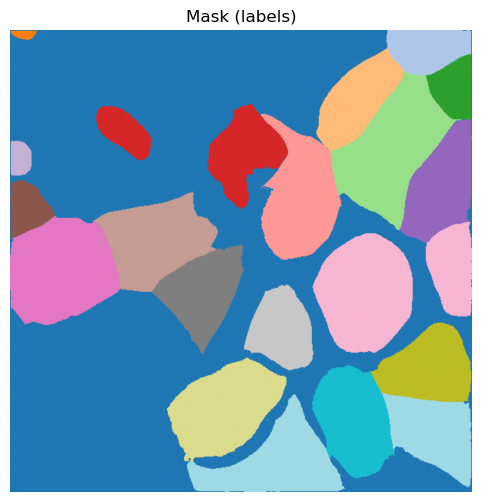

NameError: name 'outl' is not defined

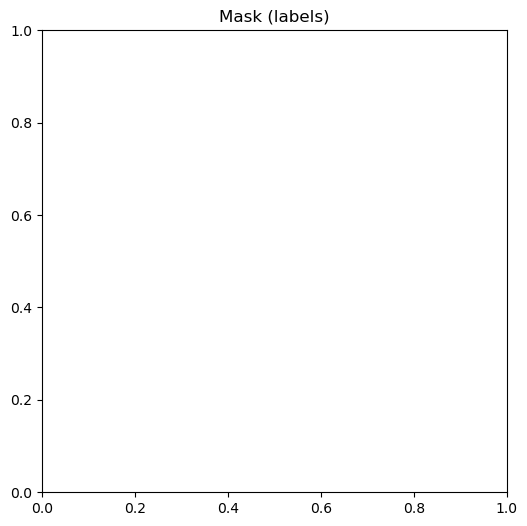

In [5]:
import os, time, numpy as np, tifffile as tiff, imageio
from pathlib import Path
from gradio_client import Client, handle_file
from perinuclear_analysis.analysis.segmentation_config import get_hf_token

# 0) Build/validate composite (if not already done)
def norm01(a):
    a = a.astype(np.float32); mn, mx = a.min(), a.max()
    return np.zeros_like(a) if mx <= mn else (a - mn) / (mx - mn)
ph_idx = channel_names.index("Phalloidin"); da_idx = channel_names.index("DAPI")
ph_mip = loaded_data[..., ph_idx].max(axis=0).astype(np.float32)
da_mip = loaded_data[..., da_idx].max(axis=0).astype(np.float32)
composite = 0.8*norm01(ph_mip) + 0.2*norm01(da_mip)
composite = np.clip(np.nan_to_num(composite, nan=0.0, posinf=1.0, neginf=0.0), 0, 1).astype(np.float32)

# 1) Write temp PNG
tmp_png = "/tmp/composite.png"
imageio.imwrite(tmp_png, (composite*255).astype(np.uint8))

# 2) Authenticated client
token = get_hf_token()
client = Client("mouseland/cellpose", hf_token=token)

# 3) Two-step flow with pause + retry
def run_seg(resize):
    _ = client.predict(filepath=handle_file(tmp_png), api_name="/update_button")
    time.sleep(1.0)
    return client.predict(
        filepath=[handle_file(tmp_png)],
        resize=resize, max_iter=250, flow_threshold=0.4, cellprob_threshold=0.0,
        api_name="/cellpose_segment",
    )

result = None
for rs in (600, 400):
    try:
        result = run_seg(rs)
        break
    except Exception as e:
        print(f"retry with smaller resize due to: {e}")
        time.sleep(1.0)

if result is None:
    raise RuntimeError("Cellpose Space failed after retries")

# 4) Read outputs and save to your folder
masks_tif = result[2]["value"] if isinstance(result[2], dict) else (result[2].path if hasattr(result[2],"path") else result[2])
outlines_png = result[3]["value"] if isinstance(result[3], dict) else (result[3].path if hasattr(result[3],"path") else result[3])

mask = tiff.imread(str(masks_tif)).astype(np.int32)
save_dir = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"); save_dir.mkdir(parents=True, exist_ok=True)
dst_mask = save_dir / f"{image_path.stem}_phall_dapi_masks.tif"
dst_outl = save_dir / f"{image_path.stem}_phall_dapi_outlines.png"
Path(dst_mask).write_bytes(Path(masks_tif).read_bytes())
Path(dst_outl).write_bytes(Path(outlines_png).read_bytes())

print("Mask:", mask.shape, "labels:", np.unique(mask).size)
print("Saved:", dst_mask, dst_outl)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.title("Mask (labels)")
plt.imshow(mask, cmap="tab20")
plt.axis("off")
plt.show()